In [ ]:
#ViT using RVE and Material properties

Epoch 1/50
80/80 [==============================] - 56s 256ms/step - loss: 1.4313 - mae: 0.7912 - val_loss: 0.7235 - val_mae: 0.5746
Epoch 2/50
80/80 [==============================] - 19s 236ms/step - loss: 0.5651 - mae: 0.4873 - val_loss: 0.4177 - val_mae: 0.3926
Epoch 3/50
80/80 [==============================] - 19s 238ms/step - loss: 0.3113 - mae: 0.3278 - val_loss: 0.1927 - val_mae: 0.2319
Epoch 4/50
80/80 [==============================] - 19s 243ms/step - loss: 0.1510 - mae: 0.2208 - val_loss: 0.0814 - val_mae: 0.1316
Epoch 5/50
80/80 [==============================] - 20s 246ms/step - loss: 0.0895 - mae: 0.1730 - val_loss: 0.0442 - val_mae: 0.1002
Epoch 6/50
80/80 [==============================] - 20s 248ms/step - loss: 0.0675 - mae: 0.1586 - val_loss: 0.0331 - val_mae: 0.0851
Epoch 7/50
80/80 [==============================] - 20s 248ms/step - loss: 0.0572 - mae: 0.1507 - val_loss: 0.0273 - val_mae: 0.0790
Epoch 8/50
80/80 [==============================] - 20s 249ms/step - 

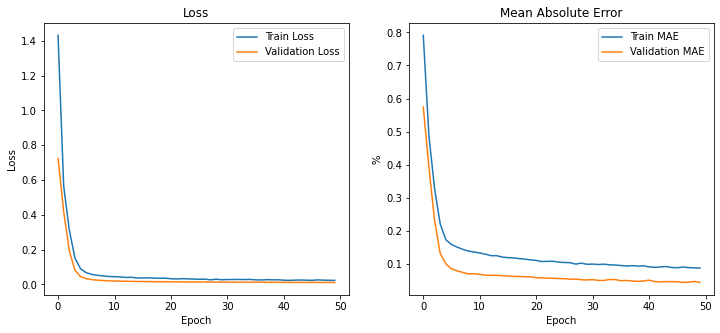

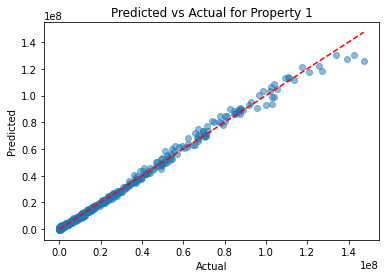

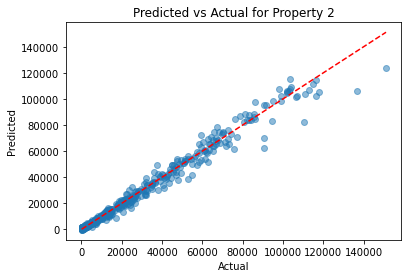

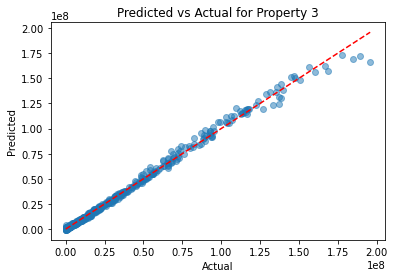

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

images = np.load('cnn_rve_masks_part2_rve.npy')
properties = np.load('cnn_homogenized_stiffness_part2.npy')

images = images.astype('float32') / 255.0
images = np.expand_dims(images, axis=-1)
#These are the material properties that we used as additional input for the model
additional_vectors = np.load('cnn_mat_props_part2.npy')

X_train_images, X_test_images, X_train_vectors, X_test_vectors, y_train, y_test = train_test_split(
    images, additional_vectors, properties, test_size=0.2, random_state=42)

scaler_vectors = StandardScaler()
X_train_vectors = scaler_vectors.fit_transform(X_train_vectors)
X_test_vectors = scaler_vectors.transform(X_test_vectors)

scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

def create_vit_model(image_input_shape, vector_input_shape, num_outputs):
    
    image_inputs = layers.Input(shape=image_input_shape, name="image_input")

    patch_size = 8
    num_patches = (image_input_shape[0] // patch_size) ** 2
    patch_dim = patch_size * patch_size * image_input_shape[-1]

    patches = layers.Reshape((num_patches, patch_dim))(image_inputs)

    positions = tf.range(start=0, limit=num_patches, delta=1)
    pos_embedding = layers.Embedding(input_dim=num_patches, output_dim=patch_dim)(positions)
    embedded_patches = patches + pos_embedding

    for _ in range(8): 
        x1 = layers.LayerNormalization(epsilon=1e-3)(embedded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=16, key_dim=patch_dim)(x1, x1)
        x2 = layers.Add()([attention_output, embedded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-3)(x2)
        x3 = layers.Dense(patch_dim, activation='relu')(x3)
        embedded_patches = layers.Add()([x3, x2])

    image_representation = layers.LayerNormalization(epsilon=1e-3)(embedded_patches)
    image_representation = layers.Flatten()(image_representation)
    image_representation = layers.Dense(512, activation='relu')(image_representation)
    image_representation = layers.Dropout(0.7)(image_representation)

    vector_inputs = layers.Input(shape=vector_input_shape, name="vector_input")
    vector_representation = layers.Dense(64, activation='relu')(vector_inputs)

    concatenated = layers.Concatenate()([image_representation, vector_representation])

    representation = layers.Dense(1024, activation='relu')(concatenated)
    representation = layers.Dropout(0.7)(representation)
    outputs = layers.Dense(num_outputs)(representation)

    model = keras.Model(inputs=[image_inputs, vector_inputs], outputs=outputs)
    return model

image_input_shape = X_train_images.shape[1:]
vector_input_shape = (X_train_vectors.shape[1],)
num_outputs = y_train.shape[1]

vit_model = create_vit_model(image_input_shape, vector_input_shape, num_outputs)
vit_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])

history = vit_model.fit([X_train_images, X_train_vectors], y_train, epochs=50, batch_size=32, validation_split=0.2)

y_pred = vit_model.predict([X_test_images, X_test_vectors])
y_pred_original_scale = scaler.inverse_transform(y_pred)
y_test_original_scale = scaler.inverse_transform(y_test)

N_temp = y_pred_original_scale.shape[0] 
accuracy  = 1 - np.sum(np.linalg.norm((y_pred_original_scale-y_test_original_scale)/y_test_original_scale))/N_temp
print(f'Accuracy: {accuracy}')

test_loss = np.mean((y_test_original_scale - y_pred_original_scale) ** 2)
test_mae = np.mean(np.abs(y_test_original_scale - y_pred_original_scale))
print(f'Test MAE (original scale): {test_mae}')

# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('%')
plt.legend()

plt.show()

# Plot predicted vs actual values for each property
properties_labels = ['Property 1', 'Property 2', 'Property 3']
for i in range(num_outputs):
    plt.figure()
    plt.scatter(y_test_original_scale[:, i], y_pred_original_scale[:, i], alpha=0.5)
    plt.plot([min(y_test_original_scale[:, i]), max(y_test_original_scale[:, i])], [min(y_test_original_scale[:, i]), max(y_test_original_scale[:, i])], color='red', linestyle='--')
    plt.title(f'Predicted vs Actual for {properties_labels[i]}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()

In [ ]:
#ViT Model only using the RVE images as input

Epoch 1/50
100/100 [==============================] - 59s 248ms/step - loss: 1.3194 - mae: 0.8107 - val_loss: 1.0116 - val_mae: 0.7218
Epoch 2/50
100/100 [==============================] - 23s 234ms/step - loss: 1.0003 - mae: 0.7316 - val_loss: 1.0117 - val_mae: 0.7218
Epoch 3/50
100/100 [==============================] - 24s 241ms/step - loss: 1.0001 - mae: 0.7318 - val_loss: 1.0117 - val_mae: 0.7222
Epoch 4/50
100/100 [==============================] - 24s 242ms/step - loss: 1.0000 - mae: 0.7312 - val_loss: 1.0117 - val_mae: 0.7216
Epoch 5/50
100/100 [==============================] - 24s 243ms/step - loss: 1.0001 - mae: 0.7310 - val_loss: 1.0117 - val_mae: 0.7212
Epoch 6/50
100/100 [==============================] - 24s 245ms/step - loss: 1.0000 - mae: 0.7308 - val_loss: 1.0116 - val_mae: 0.7212
Epoch 7/50
100/100 [==============================] - 24s 244ms/step - loss: 1.0000 - mae: 0.7310 - val_loss: 1.0117 - val_mae: 0.7213
Epoch 8/50
100/100 [==============================] - 2

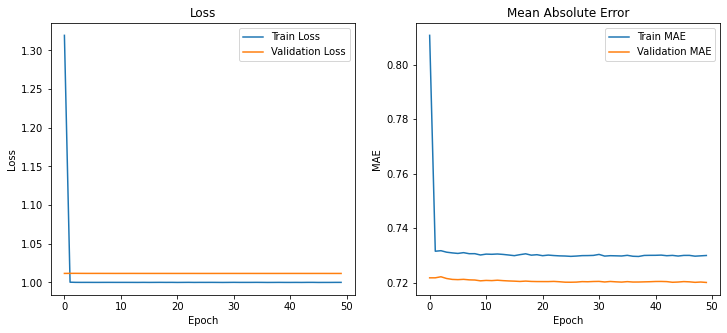

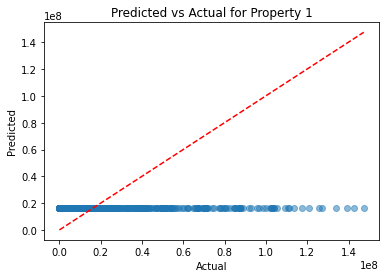

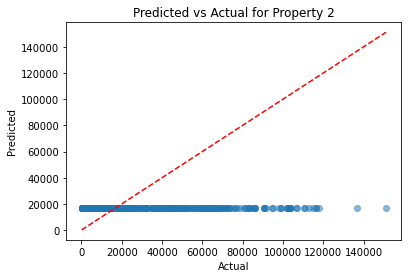

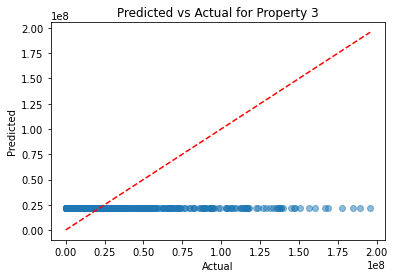

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

images = np.load('cnn_rve_masks_part2_rve.npy')
properties = np.load('cnn_homogenized_stiffness_part2.npy')

images = images.astype('float32') / 255.0
images = np.expand_dims(images, axis=-1)

X_train_images, X_test_images, y_train, y_test = train_test_split(
    images, properties, test_size=0.2, random_state=42)

scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

def create_vit_model(image_input_shape, num_outputs):
    image_inputs = layers.Input(shape=image_input_shape, name="image_input")

    patch_size = 8
    num_patches = (image_input_shape[0] // patch_size) ** 2
    patch_dim = patch_size * patch_size * image_input_shape[-1]

    patches = layers.Reshape((num_patches, patch_dim))(image_inputs)

    positions = tf.range(start=0, limit=num_patches, delta=1)
    pos_embedding = layers.Embedding(input_dim=num_patches, output_dim=patch_dim)(positions)
    pos_embedding = tf.expand_dims(pos_embedding, axis=0)
    embedded_patches = patches + pos_embedding

    for _ in range(16):  
        x1 = layers.LayerNormalization(epsilon=1e-6)(embedded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=16, key_dim=patch_dim)(x1, x1)
        x2 = layers.Add()([attention_output, embedded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = layers.Dense(patch_dim, activation='relu')(x3)
        embedded_patches = layers.Add()([x3, x2])

    image_representation = layers.LayerNormalization(epsilon=1e-6)(embedded_patches)
    image_representation = layers.Flatten()(image_representation)
    image_representation = layers.Dense(512, activation='relu')(image_representation)
    image_representation = layers.Dropout(0.7)(image_representation)

    representation = layers.Dense(1024, activation='relu')(image_representation)
    representation = layers.Dropout(0.7)(representation)
    outputs = layers.Dense(num_outputs)(representation)

    model = keras.Model(inputs=image_inputs, outputs=outputs)
    return model

image_input_shape = X_train_images.shape[1:]
num_outputs = y_train.shape[1]

vit_model = create_vit_model(image_input_shape, num_outputs)
vit_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])

history = vit_model.fit(X_train_images, y_train, epochs=50, validation_data=(X_test_images, y_test))


y_pred = vit_model.predict(X_test_images)
y_pred_original_scale = scaler.inverse_transform(y_pred)
y_test_original_scale = scaler.inverse_transform(y_test)

N_temp = y_pred_original_scale.shape[0] 
accuracy  = 1 - np.sum(np.linalg.norm((y_pred_original_scale-y_test_original_scale)/y_test_original_scale))/N_temp
print(f'Accuracy: {accuracy}')


test_mae = np.mean(np.abs(y_test_original_scale - y_pred_original_scale))
print(f'Test MAE (original scale): {test_mae}')

# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()

# Plot predicted vs actual values for each property
properties_labels = ['Property 1', 'Property 2', 'Property 3']
for i in range(num_outputs):
    plt.figure()
    plt.scatter(y_test_original_scale[:, i], y_pred_original_scale[:, i], alpha=0.5)
    plt.plot([min(y_test_original_scale[:, i]), max(y_test_original_scale[:, i])], [min(y_test_original_scale[:, i]), max(y_test_original_scale[:, i])], color='red', linestyle='--')
    plt.title(f'Predicted vs Actual for {properties_labels[i]}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()


In [ ]:
#ViT model with description of model

2024-06-06 04:13:19.297174: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-06 04:13:19.348391: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 04:13:22.303781: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9622 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3e:00.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 reshape (Reshape)           (None, 256, 64)              0         ['image_input[0][0]']         
                                                                                                  
 tf.__operators__.add (TFOp  (None, 256, 64)              0         ['reshape[0][0]']             
 Lambda)                                                                                          
                                                                                                  
 layer_normalization (Layer  (None, 256, 64)              128       ['tf.__operators__.add[0][

2024-06-06 04:13:39.490460: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-06-06 04:13:39.648890: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f99c011be60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-06 04:13:39.648932: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-06-06 04:13:39.655319: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-06 04:13:39.835606: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


80/80 [==============================] - 54s 255ms/step - loss: 1.3590 - mae: 0.7863 - val_loss: 0.6327 - val_mae: 0.5606
Epoch 2/50
80/80 [==============================] - 19s 234ms/step - loss: 0.4537 - mae: 0.4531 - val_loss: 0.2941 - val_mae: 0.3516
Epoch 3/50
80/80 [==============================] - 19s 233ms/step - loss: 0.1993 - mae: 0.2757 - val_loss: 0.0947 - val_mae: 0.1782
Epoch 4/50
80/80 [==============================] - 19s 239ms/step - loss: 0.0811 - mae: 0.1720 - val_loss: 0.0350 - val_mae: 0.0923
Epoch 5/50
80/80 [==============================] - 20s 246ms/step - loss: 0.0568 - mae: 0.1484 - val_loss: 0.0239 - val_mae: 0.0749
Epoch 6/50
80/80 [==============================] - 20s 247ms/step - loss: 0.0539 - mae: 0.1455 - val_loss: 0.0206 - val_mae: 0.0702
Epoch 7/50
80/80 [==============================] - 20s 248ms/step - loss: 0.0473 - mae: 0.1401 - val_loss: 0.0193 - val_mae: 0.0680
Epoch 8/50
80/80 [==============================] - 20s 249ms/step - loss: 0.044

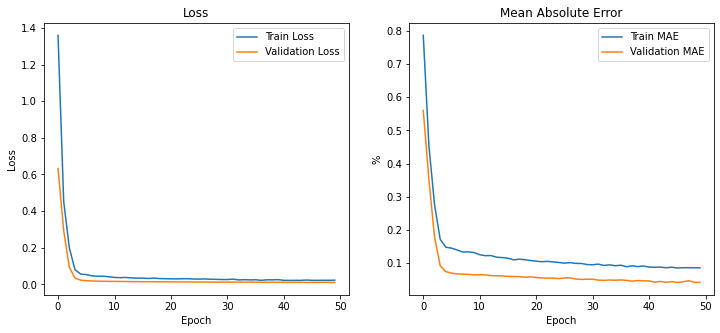

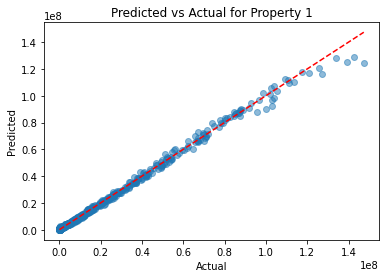

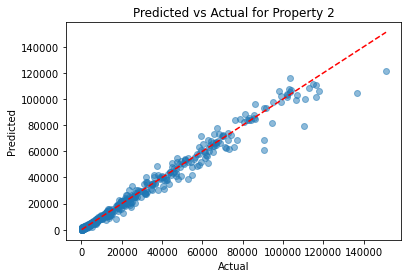

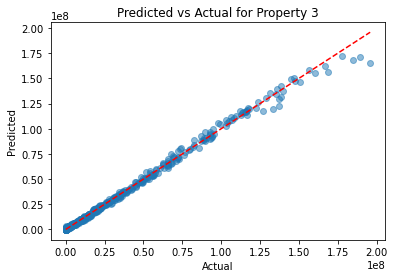

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

images = np.load('cnn_rve_masks_part2_rve.npy')
#These are the predcited homogenized properties
properties = np.load('cnn_homogenized_stiffness_part2.npy')

images = images.astype('float32') / 255.0
images = np.expand_dims(images, axis=-1)
#These are the properties from each material
additional_vectors = np.load('cnn_mat_props_part2.npy')

X_train_images, X_test_images, X_train_vectors, X_test_vectors, y_train, y_test = train_test_split(
    images, additional_vectors, properties, test_size=0.2, random_state=42)

scaler_vectors = StandardScaler()
X_train_vectors = scaler_vectors.fit_transform(X_train_vectors)
X_test_vectors = scaler_vectors.transform(X_test_vectors)

scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

def create_vit_model(image_input_shape, vector_input_shape, num_outputs):
    image_inputs = layers.Input(shape=image_input_shape, name="image_input")

    patch_size = 8
    num_patches = (image_input_shape[0] // patch_size) ** 2
    patch_dim = patch_size * patch_size * image_input_shape[-1]

    patches = layers.Reshape((num_patches, patch_dim))(image_inputs)

    positions = tf.range(start=0, limit=num_patches, delta=1)
    pos_embedding = layers.Embedding(input_dim=num_patches, output_dim=patch_dim)(positions)
    embedded_patches = patches + pos_embedding

    for _ in range(16): 
        x1 = layers.LayerNormalization(epsilon=1e-3)(embedded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=16, key_dim=patch_dim)(x1, x1)
        x2 = layers.Add()([attention_output, embedded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-3)(x2)
        x3 = layers.Dense(patch_dim, activation='relu')(x3)
        embedded_patches = layers.Add()([x3, x2])

    image_representation = layers.LayerNormalization(epsilon=1e-3)(embedded_patches)
    image_representation = layers.Flatten()(image_representation)
    image_representation = layers.Dense(512, activation='relu')(image_representation)
    image_representation = layers.Dropout(0.7)(image_representation)

    vector_inputs = layers.Input(shape=vector_input_shape, name="vector_input")
    vector_representation = layers.Dense(64, activation='relu')(vector_inputs)

    concatenated = layers.Concatenate()([image_representation, vector_representation])

    representation = layers.Dense(1024, activation='relu')(concatenated)
    representation = layers.Dropout(0.7)(representation)
    outputs = layers.Dense(num_outputs)(representation)

    model = keras.Model(inputs=[image_inputs, vector_inputs], outputs=outputs)
    return model

image_input_shape = X_train_images.shape[1:]
vector_input_shape = (X_train_vectors.shape[1],)
num_outputs = y_train.shape[1]

vit_model = create_vit_model(image_input_shape, vector_input_shape, num_outputs)
vit_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])

# Print the model summary
vit_model.summary()

history = vit_model.fit([X_train_images, X_train_vectors], y_train, epochs=50, batch_size=32, validation_split=0.2)

y_pred = vit_model.predict([X_test_images, X_test_vectors])
y_pred_original_scale = scaler.inverse_transform(y_pred)
y_test_original_scale = scaler.inverse_transform(y_test)

N_temp = y_pred_original_scale.shape[0] 
accuracy  = 1 - np.sum(np.linalg.norm((y_pred_original_scale-y_test_original_scale)/y_test_original_scale))/N_temp
print(f'Accuracy: {accuracy}')

test_loss = np.mean((y_test_original_scale - y_pred_original_scale) ** 2)
test_mae = np.mean(np.abs(y_test_original_scale - y_pred_original_scale))
print(f'Test MAE (original scale): {test_mae}')

# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('%')
plt.legend()

plt.show()

# Plot predicted vs actual values for each property
properties_labels = ['Property 1', 'Property 2', 'Property 3']
for i in range(num_outputs):
    plt.figure()
    plt.scatter(y_test_original_scale[:, i], y_pred_original_scale[:, i], alpha=0.5)
    plt.plot([min(y_test_original_scale[:, i]), max(y_test_original_scale[:, i])], [min(y_test_original_scale[:, i]), max(y_test_original_scale[:, i])], color='red', linestyle='--')
    plt.title(f'Predicted vs Actual for {properties_labels[i]}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()